# Covid-19 Deaths Predictions using GRU Recurrent model

Importing the required python packages

In [47]:
import pandas as pd
import requests
import io
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping 
from keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


Converting the data in CSV format to Data Frame

In [48]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'  , sep = ',')

cols = df.T.iloc[4: , :  ].diff().fillna(0).T
df = pd.concat([df.iloc[: , 0:4] , cols]  , axis = 1 ) 
df.drop('Province/State' , axis = 1 , inplace = True)
cols = df.columns

dd  = pd.DataFrame(columns= cols)

def fun(frame):
    
    mean_lat = frame['Lat'].mean() 
    meanlong = frame['Long'].mean() 
    country = frame['Country/Region'].values[0]
    # print(frame)
    a = frame.agg('sum')
    a.Lat = mean_lat 
    a.Long = meanlong 
    a['Country/Region'] = country
    vals = a.values
    dd.loc[len(dd.index)] = list(vals)  

df.groupby(['Country/Region']).apply(lambda frame  : fun(frame) )

death_trend = dd.iloc[: , 3 : ].agg('sum')
death_trend.rolling(100).mean().dropna(inplace = True)
deaths_day_wise = death_trend.values
standardDeviation = deaths_day_wise.std()
variance = np.sqrt(standardDeviation)
average = deaths_day_wise.mean()
MAD = death_trend.mad()
AAD = death_trend.mad()
print(average, variance, standardDeviation, MAD , AAD) 

6336.857824427481 64.07567205682585 4105.691749533894 3371.0137794271895 3371.0137794271895


C:\Users\Student\AppData\Local\Temp\ipykernel_900\3358960019.py:31: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  MAD = death_trend.mad()
C:\Users\Student\AppData\Local\Temp\ipykernel_900\3358960019.py:32: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  AAD = death_trend.mad()


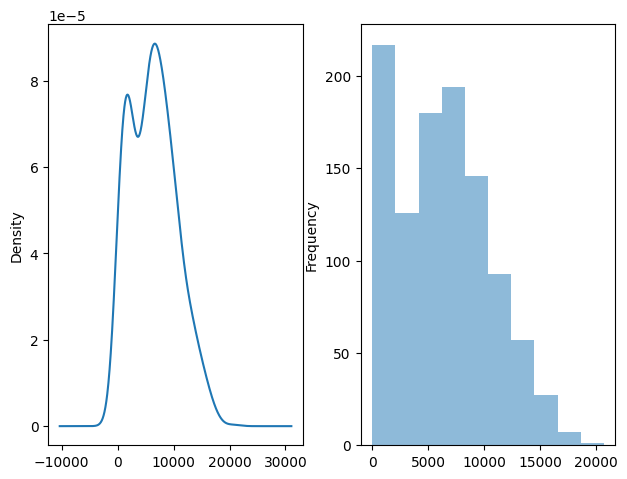

In [49]:
# It only gives how many data points may be present around specified values.
fig, (ax1 , ax2) = plt.subplots(1 ,2 , sharey=False ,sharex= False)
fig.tight_layout()
ax1 = death_trend.plot.kde(bw_method = 0.3 , ax = ax1)
ax2 = death_trend.plot.hist(alpha=0.5 , ax = ax2)
plt.show()


From above plots it is visible that most of the countries have experienced 6000-8000 deaths 

(-52.35, 1099.35, -1035.1000000000001, 21737.1)

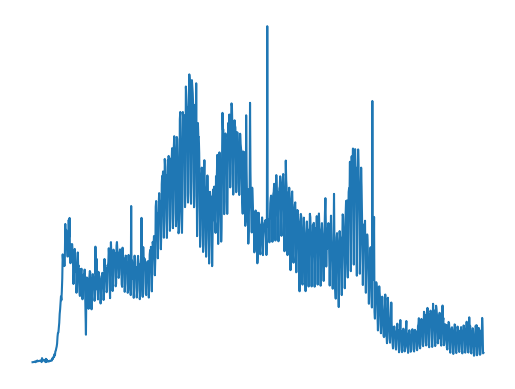

In [50]:
ax = plt.plot(death_trend)
plt.axis('off')

In [51]:
split_size = 0.80
split_ndx = int(dd.shape[0]*split_size )

dd = dd.drop(['Lat' , 'Long'] , axis = 1 ).set_index('Country/Region')
train_df = dd.iloc[ : split_ndx , : ]
test_df =  dd.iloc[split_ndx : , :  ]  
cols = dd.columns

d = {} 

for i in cols : 
    d[i] = tf.int16
    

Creating data in TensorFlow Format

In [52]:
my_ds_train = tf.data.Dataset.from_tensor_slices(dict(train_df))
my_ds_test = tf.data.Dataset.from_tensor_slices(dict(test_df))

# Optionally define a custom `data_dir`.
# If None, then the default data dir is used.



# Define the builder.

covid_death_builder = tfds.dataset_builders.TfDataBuilder(
    name="Covid deaths",
    config="CovidData",
    version="1.0.0",
    split_datasets={
        "train": my_ds_train,
        "test": my_ds_test,
    },
    features=tfds.features.FeaturesDict(d),
    description="Dataset with covid deaths",
    release_notes={
        "1.0.0": "Initial release with deaths till 22 November , 2022",
    }
)

# Make the builder store the data as a TFDS dataset.
covid_death_builder.download_and_prepare()

In [53]:
df = dd.copy()

In [54]:
df22 = df.T[4:]

In [55]:
df22['Sum'] = df22.sum(axis=1)

In [56]:
df22.head(2)

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe,Sum
1/26/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
1/27/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,26


In [57]:
dates = df.index

In [58]:
dates_prediction = dates[-194:]

# Splitting of Data

In [59]:
df = df22
close_data = df['Sum'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

# date_train = df['Date'][:split]
# date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

835
209


In [60]:
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [61]:
model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 125
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/125


C:\Users\Student\AppData\Local\Temp\ipykernel_900\3894425179.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=num_epochs, verbose=1)


41/41 [==============================] - 3s 7ms/step - loss: 40672016.0000
Epoch 2/125
41/41 [==============================] - 0s 7ms/step - loss: 39037292.0000
Epoch 3/125
41/41 [==============================] - 0s 8ms/step - loss: 38727812.0000
Epoch 4/125
41/41 [==============================] - 0s 8ms/step - loss: 23748598.0000
Epoch 5/125
41/41 [==============================] - 0s 8ms/step - loss: 33712844.0000
Epoch 6/125
41/41 [==============================] - 0s 8ms/step - loss: 22568936.0000
Epoch 7/125
41/41 [==============================] - 0s 9ms/step - loss: 18918258.0000
Epoch 8/125
41/41 [==============================] - 0s 7ms/step - loss: 20574842.0000
Epoch 9/125
41/41 [==============================] - 0s 8ms/step - loss: 21773674.0000
Epoch 10/125
41/41 [==============================] - 0s 7ms/step - loss: 20209140.0000
Epoch 11/125
41/41 [==============================] - 0s 7ms/step - loss: 10807164.0000
Epoch 12/125
41/41 [==============================] -

In [62]:
prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))
#prediction

C:\Users\Student\AppData\Local\Temp\ipykernel_900\1585461578.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction = model.predict_generator(test_generator)


# Accuracy for LSTM model

In [63]:
# correct = df['Sum'].values
correct = close_test.reshape((-1,1))
correct = correct[-194:]
#len(correct)

In [64]:
#len(prediction)

In [65]:
mse = ((correct - prediction)**2).mean()

# Prediction of deaths along with the dates

In [66]:
#dates_prediction

In [67]:
type(dates_prediction) 
deaths_dates = pd.DataFrame(dates_prediction)

In [68]:
deaths_dates['Deaths'] = prediction

In [69]:
#df22

In [70]:
df22 = df22.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
#df22

In [71]:
df_new = df22[['Sum']].copy()

In [72]:
def partition_dataset(sequence_length, data, index):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Model training - LSTM

In [73]:
def getNext(feature, model):
    df22 = df_new
    data = df22
    data_filtered = df22
    data_filtered_ext = data_filtered.copy()
    data_filtered_ext['Prediction'] = data_filtered_ext[feature]

    nrows = data_filtered.shape[0]

    # Convert the data to numpy values
    np_data_unscaled = np.array(data_filtered)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))
#     print(np_data.shape)

    # Transform the data by scaling each feature to a range between 0 and 1
    scaler = MinMaxScaler()
#     print(np_data_unscaled.shape)
    np_data_scaled = scaler.fit_transform(np_data_unscaled)

    # Creating a separate scaler that works on a single column for scaling predictions
    scaler_pred = MinMaxScaler()
    df_Close = pd.DataFrame(data_filtered_ext[feature])
    np_Close_scaled = scaler_pred.fit_transform(df_Close)
    # Set the sequence length - this is the timeframe used to make a single prediction
#     -----------------------------------------------------------------------------------------------------------------------------
    # sequencing
    sequence_length = 3

    # Prediction Index
    index = data.columns.get_loc(feature)

    # Split the training data into train and train data sets
    # As a first step, we get the number of rows to train the model on 80% of the data 
    train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

    # Create the training and test data
    train_data = np_data_scaled[0:train_data_len, :]
    test_data = np_data_scaled[train_data_len - sequence_length:, :]



    # Generate training data and test data
    x_train, y_train = partition_dataset(sequence_length, train_data, index)
    x_test, y_test = partition_dataset(sequence_length, test_data, index)

    # Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
#     print(x_train.shape, y_train.shape)
#     print(x_test.shape, y_test.shape)

#     print(x_train[1][sequence_length-1][index])
#     print(y_train[0])
#     -----------------------------------------------------------------------------------------------------------------------------

#     model = Sequential()

    # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
    n_neurons = x_train.shape[1] * x_train.shape[2]
#     print(n_neurons, x_train.shape[1], x_train.shape[2])
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(5))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
#-----------------------------------------------------------------------------------------------------------------------------
    epochs = 1
    batch_size = 8
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs,
                        validation_data=(x_train, y_train)
                    )
#-----------------------------------------------------------------------------------------------------------------------------
#     print(model.summary)
    df_temp = df22[-sequence_length:]
    new_df = df_temp
    new_df
    # N = sequence_length

    # # Get the last N day closing price values and scale the data to be values between 0 and 1
    last_N_days = new_df[-sequence_length:].values
    # print("last_N_days")
    # print((last_N_days))
    # print(last_N_days)
    # last_N_days = last_N_days.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
    last_N_days_scaled = scaler.transform(last_N_days)
    # # Create an empty list and Append past N days
    X_test_new = []
    X_test_new.append(last_N_days_scaled)
    # print("X_test_new")
    # print(X_test_new)
    # Convert the X_test data set to a numpy array and reshape the data
    pred_price_scaled = model.predict(np.array(X_test_new))
    # print(pred_price_scaled)
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
    # print(pred_price_unscaled)
# Print last price and predicted price for the next day
#     print(pred_price_scaled)
#     print(new_df[feature][-1:])
    price_today = np.round(new_df[feature][-1:], 2)
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

    plus = '+'; minus = ''
    print(f'The predicted value for feature (', {feature}, "):  " ,{predicted_price})
    return predicted_price

In [74]:
# for col in df22.columns:
#   print(df22[col].value_counts())

# Prediction for next 7 days covid deaths.


---



In [75]:
next_7_days = []
for i in range(7):
  m = Sequential()
  tmp = getNext('Sum', m)
  df_new.loc[len(df_new)]= tmp
  next_7_days.append(tmp)

1/1 [==============================] - 2s 2s/step
The predicted value for feature ( {'Sum'} ):   {6461.53}
1/1 [==============================] - 2s 2s/step
The predicted value for feature ( {'Sum'} ):   {7376.69}
1/1 [==============================] - 2s 2s/step
The predicted value for feature ( {'Sum'} ):   {7241.26}
1/1 [==============================] - 2s 2s/step
The predicted value for feature ( {'Sum'} ):   {7649.91}


C:\Users\Student\AppData\Local\Temp\ipykernel_900\2259744108.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  price_today = np.round(new_df[feature][-1:], 2)


1/1 [==============================] - 2s 2s/step
The predicted value for feature ( {'Sum'} ):   {7882.12}


C:\Users\Student\AppData\Local\Temp\ipykernel_900\2259744108.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  price_today = np.round(new_df[feature][-1:], 2)


1/1 [==============================] - 2s 2s/step
The predicted value for feature ( {'Sum'} ):   {7459.11}


C:\Users\Student\AppData\Local\Temp\ipykernel_900\2259744108.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  price_today = np.round(new_df[feature][-1:], 2)


1/1 [==============================] - 2s 2s/step
The predicted value for feature ( {'Sum'} ):   {7678.54}


C:\Users\Student\AppData\Local\Temp\ipykernel_900\2259744108.py:102: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  price_today = np.round(new_df[feature][-1:], 2)


In [76]:
A = [int(a) for a in next_7_days]
print("Average of next 7-Days Predicted Cases: ",int(np.mean(A)))

Average of next 7-Days Predicted Cases:  7392


In [77]:
from datetime import date, timedelta

dates = []
for i in range(1,8):
    days_after = (date.today()+timedelta(days=i)).isoformat()  
    dates.append(days_after)

#print(dates[0])

In [78]:
dict_dates_deaths = {dates[0] : A[0], dates[1] : A[1], dates[2] : A[2], dates[3] : A[3], dates[4] : A[4], dates[5] : A[5], dates[6] : A[6]}
#print(dict_dates_deaths)

# LSTMPredictions_Deaths

Predicted Deaths for the next 7 days:
 {'2022-12-06': 6461, '2022-12-07': 7376, '2022-12-08': 7241, '2022-12-09': 7649, '2022-12-10': 7882, '2022-12-11': 7459, '2022-12-12': 7678}


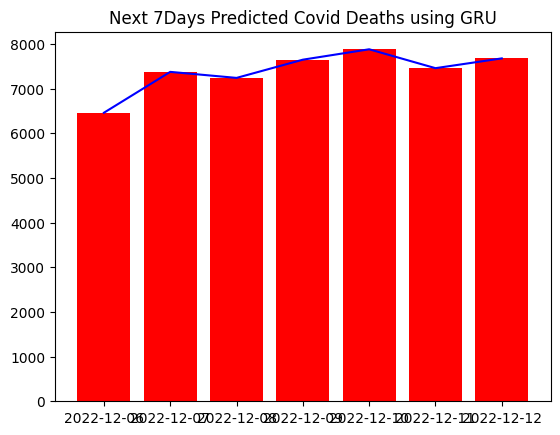

In [79]:
dict_dates_deaths
print("Predicted Deaths for the next 7 days:\n",dict_dates_deaths)

names = list(dict_dates_deaths.keys())
values = list(dict_dates_deaths.values())

plt.bar(range(len(dict_dates_deaths)), values, tick_label=names, color='red')
plt.plot(names,values,color='blue')
plt.title("Next 7Days Predicted Covid Deaths using GRU")
plt.show()

# Data Analysis and Visualization


In [80]:
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'  , sep = ',')
df_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'  , sep = ',')

In [81]:
# No null values any dates
df_deaths = df_deaths.drop_duplicates(subset=['Country/Region'])
df_cases = df_cases.drop_duplicates(subset=['Country/Region'])
df_deaths.isna().sum()[4 :].values.sum()
df_cases.isna().sum()[4 :].values.sum()


0

In [82]:
cols_deaths = df_deaths.T.iloc[4: , :  ].diff().fillna(0).T
cols_cases = df_cases.T.iloc[4: , :  ].diff().fillna(0).T
df_deaths = pd.concat([df_deaths.iloc[: , 0:4] , cols_deaths]  , axis = 1 ) 
df_cases = pd.concat([df_cases.iloc[: , 0:4] , cols_cases]  , axis = 1 )

In [83]:
data_deaths = df_deaths.groupby(['Country/Region']).agg('sum').reset_index()
data_deaths = data_deaths.drop_duplicates(subset = ['Country/Region']).reset_index()
data_deaths.loc[ : , ['Lat' , 'Long']]= df_deaths.drop_duplicates(subset = ['Country/Region']).loc[ : , ['Lat' , 'Long']]
data_deaths.drop('index' , axis = 1 , inplace = True )
data_cases = df_cases.groupby(['Country/Region']).agg('sum').reset_index()
data_cases = data_cases.drop_duplicates(subset = ['Country/Region']).reset_index()
data_cases.loc[ : , ['Lat' , 'Long']]= df_cases.drop_duplicates(subset = ['Country/Region']).loc[ : , ['Lat' , 'Long']]
data_cases.drop('index' , axis = 1 , inplace = True )

C:\Users\Student\AppData\Local\Temp\ipykernel_900\3345493972.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_deaths = df_deaths.groupby(['Country/Region']).agg('sum').reset_index()
C:\Users\Student\AppData\Local\Temp\ipykernel_900\3345493972.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_cases = df_cases.groupby(['Country/Region']).agg('sum').reset_index()


In [84]:
#Cpnfirmed_Cases_Global
x_cases= data_cases.iloc[: , 3 : ].sum(axis=1).tolist()
countrylist_cases = df_cases['Country/Region'].tolist()
d_cases = {'Country' : countrylist_cases, 'Cases' : x_cases}
temp_df_cases = pd.DataFrame(d_cases)
temp_df_cases = temp_df_cases.sort_values(by='Cases', ascending=False)
#print(temp_df_c)

Text(0.5, 1.0, 'Top ten countries with highest no. of Cases')

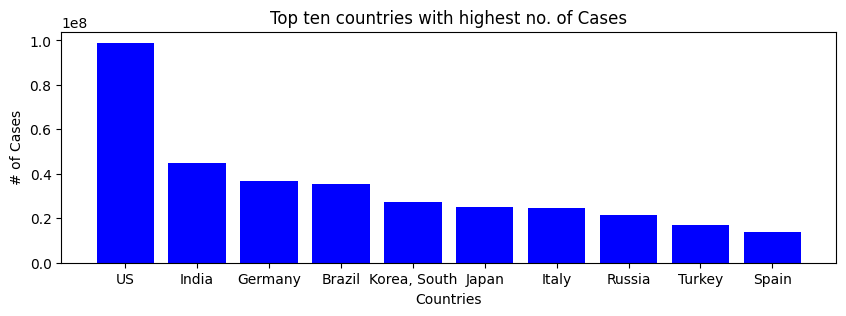

In [85]:
plt.figure(figsize=(10,3))
plt.bar(temp_df_cases['Country'].head(10).tolist(), temp_df_cases['Cases'].head(10).tolist(),color='blue')
plt.xlabel("Countries")
plt.ylabel("# of Cases")
plt.title("Top ten countries with highest no. of Cases")

Text(0.5, 1.0, 'Top ten countries with highest no. of deaths')

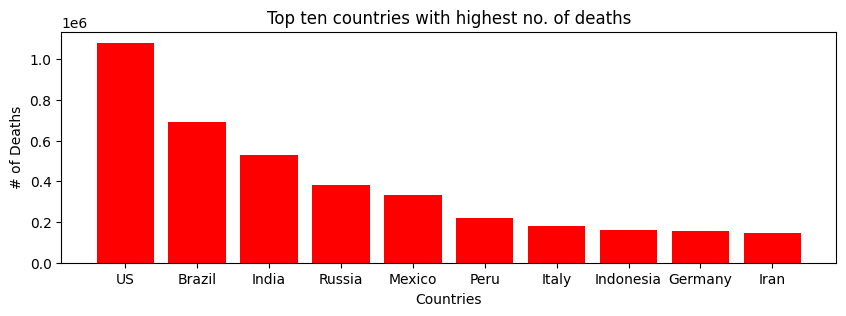

In [86]:
#Confirmed_Deaths_Global
x= data_deaths.iloc[: , 3 : ].sum(axis=1).tolist()
countrylist = df_deaths['Country/Region'].tolist()
d = {'Country' : countrylist, 'Deaths' : x}
temp_df = pd.DataFrame(d)
temp_df = temp_df.sort_values(by='Deaths', ascending=False)
#print(temp_df)

plt.figure(figsize=(10,3))
plt.bar(temp_df['Country'].head(10).tolist(), temp_df['Deaths'].head(10).tolist(),color='red')
plt.xlabel("Countries")
plt.ylabel("# of Deaths")
plt.title("Top ten countries with highest no. of deaths")

In [87]:
cases_trend = data_cases.iloc[: , 3 : ].agg('sum')
cases_trend.rolling(100).mean().dropna(inplace = True)

death_trend = data_deaths.iloc[: , 3 : ].agg('sum')
death_trend.rolling(100).mean().dropna(inplace = True)

dfheaders_cases = df_cases.columns.values.tolist()
dfheaders_deaths = df_deaths.columns.values.tolist()

In [88]:


def mean_cases():
  list_mean_cases = df_cases.mean(axis=0)
  MEANlist_cases = list_mean_cases.tolist()
  #print(MEANlist)
  res_max_cases = MEANlist_cases.index(max(MEANlist_cases))
  print("Max Mean date of Confirmed cases: ",dfheaders_cases[res_max_cases + 5])
  res_min_cases = MEANlist_cases.index(min(MEANlist_cases))
  print("Min Mean date of Confirmed cases: ",dfheaders_cases[res_min_cases + 5])
  plt.figure(figsize=(10,3))
  plt.plot(MEANlist_cases,color='blue')
  plt.title("MEAN of Confirmed Cases")
  plt.xlabel("# of Days since 1/22/2020")
  plt.show()

def mean_deaths():
  list_mean = df_deaths.mean(axis=0)
  MEANlist = list_mean.tolist()
  #print(MEANlist)
  res_max = MEANlist.index(max(MEANlist))
  print("Max Mean date of deaths: ",dfheaders_deaths[res_max + 5])
  res_min = MEANlist.index(min(MEANlist))
  print("Min Mean date of deaths: ",dfheaders_deaths[res_min + 5])
  plt.figure(figsize=(10,3))
  plt.plot(MEANlist,color='red')
  plt.title("MEAN of Confirmed Deaths")
  plt.xlabel("# of Days since 1/22/2020")
  plt.show()

def median_cases():
  list_median_cases = df_cases.median(axis=0)
  MEDIANlist_cases = list_median_cases.tolist()
  #print(MEDIANlist_cases)
  res_max_cases = MEDIANlist_cases.index(max(MEDIANlist_cases))
  print("Max Median date in Confirmed Cases: ",dfheaders_cases[res_max_cases + 5])
  res_min_cases = MEDIANlist_cases.index(min(MEDIANlist_cases))
  print("Min Median date in Confirmed Cases: ",format(dfheaders_cases[res_min_cases + 5]))
  plt.figure(figsize=(10,3))
  plt.plot(MEDIANlist_cases,color='blue')
  plt.title("MEDIAN of Confirmed Cases")
  plt.xlabel("# of Days since 1/22/2020")
  plt.show()

def median_deaths():
  list_median = df_deaths.median(axis=0)
  MEDIANlist = list_median.tolist()
  #print(MEDIANlist)
  res_max = MEDIANlist.index(max(MEDIANlist))
  print("Max Median date in Deaths: ",dfheaders_deaths[res_max + 5])
  res_min = MEDIANlist.index(min(MEDIANlist))
  print("Min Median date in Deaths:: ",format(dfheaders_deaths[res_min + 5]))
  plt.figure(figsize=(10,3))
  plt.plot(MEDIANlist,color='red')
  plt.title("MEDIAN of Confirmed Deaths")
  plt.xlabel("# of Days since 1/22/2020")
  plt.show()

def std_cases():
  list_std_cases = df_cases.std(axis=0)
  STDlist_cases = list_std_cases.tolist()
  #print(STDlist_cases)
  res_max_cases = STDlist_cases.index(max(STDlist_cases))
  print("Max Standard Deviation date in Confimred cases: ",dfheaders_cases[res_max_cases + 5])
  res_min_cases = STDlist_cases.index(min(STDlist_cases))
  print("Min Standard Deviation date in Confirmed cases: ",format(dfheaders_cases[res_min_cases + 5]))
  plt.figure(figsize=(10,3))
  plt.plot(STDlist_cases,color='blue')
  plt.title("STANDARD DEVIATION of Confirmed Cases")
  plt.xlabel("# of Days since 1/22/2020")
  plt.show()

def std_deaths():
  list_std = df_deaths.std(axis=0)
  STDlist = list_std.tolist()
  #print(STDlist)
  res_max = STDlist.index(max(STDlist))
  print("Max Standard Deviation date in Deaths: ",dfheaders_deaths[res_max + 5])
  res_min = STDlist.index(min(STDlist))
  print("Min Standard Deviation date in Deaths: ",format(dfheaders_deaths[res_min + 5]))
  plt.figure(figsize=(10,3))
  plt.plot(STDlist,color='red')
  plt.title("STANDARD DEVIATION of Confirmed Deaths")
  plt.xlabel("# of Days since 1/22/2020")
  plt.show()

def variance_cases():
  list_variance_cases = df_cases.var(axis=0)
  VARIANCElist_cases = list_variance_cases.tolist()
  #print(VARIANCElist_cases)
  res_max_cases = VARIANCElist_cases.index(max(VARIANCElist_cases))
  print("Max Variance date in Confirmed cases: ",dfheaders_cases[res_max_cases + 5])
  res_min_cases = VARIANCElist_cases.index(min(VARIANCElist_cases))
  print("Min Variance date in Confirmed cases: ",format(dfheaders_cases[res_min_cases + 5]))
  plt.figure(figsize=(10,3))
  plt.plot(VARIANCElist_cases, color='blue')
  plt.title("VARIANCE of Confirmed Cases")
  plt.xlabel("# of Days since 1/22/2020")
  plt.show()

def variance_deaths():
  list_variance = df_deaths.var(axis=0)
  VARIANCElist = list_variance.tolist()
  #print(VARIANCElist)
  res_max = VARIANCElist.index(max(VARIANCElist))
  print("Max Variance date in Deaths: ",dfheaders_deaths[res_max + 5])
  res_min = VARIANCElist.index(min(VARIANCElist))
  print("Min Variance date in Deaths: ",format(dfheaders_deaths[res_min + 5]))
  plt.figure(figsize=(10,3))
  plt.plot(VARIANCElist, color='red')
  plt.title("VARIANCE of Confirmed Deaths")
  plt.xlabel("# of Days since 1/22/2020")
  plt.show()

def aad_cases():
  list_aad_cases = df_cases.mad(axis=0)
  AADlist_cases = list_aad_cases.tolist()
  #print(AADlist)
  res_max_cases = AADlist_cases.index(max(AADlist_cases))
  print("Max AAD date in Confirmed cases: ",dfheaders_cases[res_max_cases + 5])
  res_min_cases = AADlist_cases.index(min(AADlist_cases))
  print("Min AAD date in Confirmed cases: ",format(dfheaders_cases[res_min_cases + 5]))
  plt.figure(figsize=(10,3))
  plt.plot(AADlist_cases, color='blue')
  plt.title("AAD of Confirmed Cases")
  plt.xlabel("# of Days since 1/22/2020")
  plt.show()

def aad_deaths():
  list_aad = df_deaths.mad(axis=0)
  AADlist = list_aad.tolist()
  #print(AADlist)
  res_max = AADlist.index(max(AADlist))
  print("Max AAD date in Deaths: ",dfheaders_deaths[res_max + 5])
  res_min = AADlist.index(min(AADlist))
  print("Min AAD date in Deaths: ",format(dfheaders_deaths[res_min + 5]))
  plt.figure(figsize=(10,3))
  plt.plot(AADlist, color='red')
  plt.title("AAD of Confirmed Deaths")
  plt.xlabel("# of Days since 1/22/2020")
  plt.show()

from scipy.interpolate.fitpack2 import concatenate
from statistics import median
from scipy.stats import median_abs_deviation
def mad_cases():
  MADlist_cases = []
  for index_cases, item_cases in enumerate(dfheaders_cases):
    if index_cases > 3:
      datelist_cases = item_cases
      listvalues_cases = df_cases[datelist_cases].tolist()
      listvalues_cases = [i for i in listvalues_cases if i != 0]
      if len(listvalues_cases) == 0:
        median_absolute_deviation_cases = 0
        MADlist_cases.append(median_absolute_deviation_cases)
        #print(median_absolute_deviation_cases)
      else:
        median_absolute_deviation_cases = median_abs_deviation(listvalues_cases)
        MADlist_cases.append(median_absolute_deviation_cases)
        #print(median_absolute_deviation_cases)
  #print(MADlist_cases)
  #print(max(MADlist_cases))
  #print(MADlist.index(max(MADlist_cases)))
  res_max_cases = MADlist_cases.index(max(MADlist_cases))
  print("Max MAD date in Confirmed Cases: ",dfheaders_cases[res_max_cases + 5])
  res_min_cases = MADlist_cases.index(min(MADlist_cases))
  print("Min MAD date in Confirmed Cases:",format(dfheaders_cases[res_min_cases + 5]))
  plt.figure(figsize=(10,3))
  #print(MADlist_cases)
  plt.plot(MADlist_cases,color='blue')
  plt.title("MAD of Confirmed Cases")
  plt.xlabel("# of Days since 1/22/2020")
  plt.show()

def mad_deaths():
  MADlist = []
  for index, item in enumerate(dfheaders_deaths):
    if index > 3:
      datelist = item
      listvalues = df_deaths[datelist].tolist()
      listvalues = [i for i in listvalues if i != 0]
      if len(listvalues) == 0:
        median_absolute_deviation = 0
        MADlist.append(median_absolute_deviation)
        #print(median_absolute_deviation)
      else:
        median_absolute_deviation = median_abs_deviation(listvalues)
        MADlist.append(median_absolute_deviation)
        #print(median_absolute_deviation)
  #print(MADlist)
  #print(max(MADlist))
  #print(MADlist.index(max(MADlist)))
  res_max = MADlist.index(max(MADlist))
  print("Max MAD date in Deaths: ",dfheaders_deaths[res_max + 5])
  res_min = MADlist.index(min(MADlist))
  print("Min MAD date in Deaths: ",format(dfheaders_deaths[res_min + 5]))
  plt.figure(figsize=(10,3))
  #print(MADlist)
  plt.plot(MADlist,color='red')
  plt.title("MAD of Confirmed Deaths")


C:\Users\Student\AppData\Local\Temp\ipykernel_900\477869190.py:141: DeprecationWarning: Please use `concatenate` from the `scipy.interpolate` namespace, the `scipy.interpolate.fitpack2` namespace is deprecated.
  from scipy.interpolate.fitpack2 import concatenate


C:\Users\Student\AppData\Local\Temp\ipykernel_900\477869190.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  list_mean_cases = df_cases.mean(axis=0)


Max Mean date of Confirmed cases:  1/22/22
Min Mean date of Confirmed cases:  1/25/20


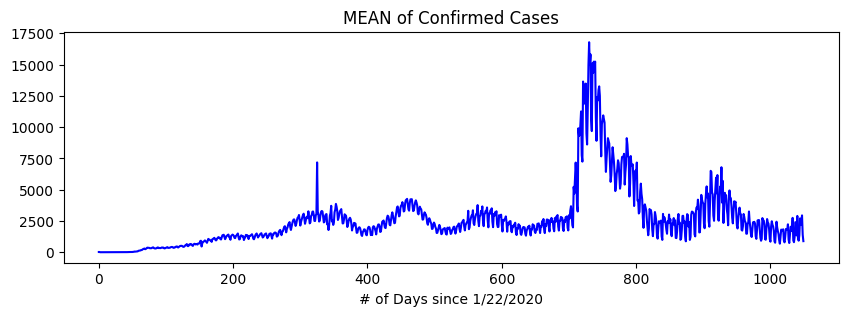

C:\Users\Student\AppData\Local\Temp\ipykernel_900\477869190.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  list_mean = df_deaths.mean(axis=0)


Max Mean date of deaths:  7/23/21
Min Mean date of deaths:  1/25/20


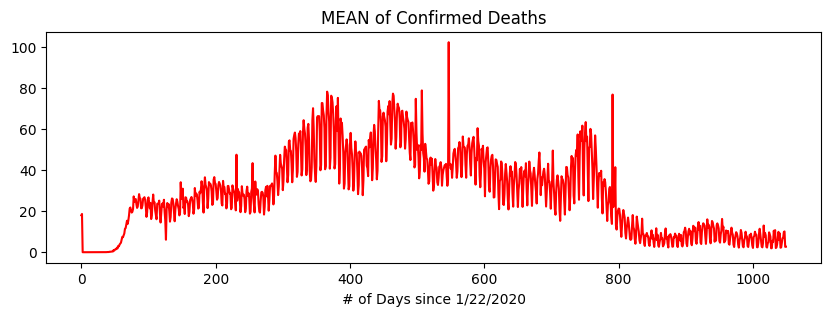

C:\Users\Student\AppData\Local\Temp\ipykernel_900\477869190.py:30: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  list_median_cases = df_cases.median(axis=0)


Max Median date in Confirmed Cases:  1/22/22
Min Median date in Confirmed Cases:  1/25/20


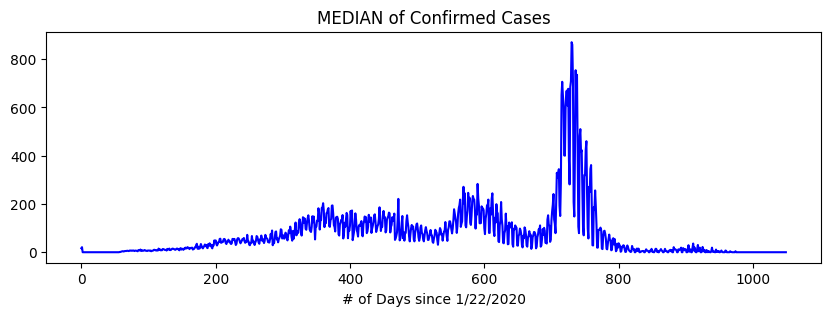

C:\Users\Student\AppData\Local\Temp\ipykernel_900\477869190.py:44: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  list_median = df_deaths.median(axis=0)


Max Median date in Deaths:  1/24/20
Min Median date in Deaths::  1/25/20


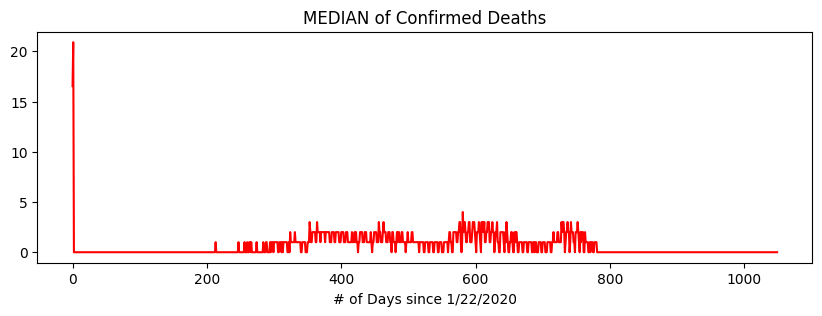

C:\Users\Student\AppData\Local\Temp\ipykernel_900\477869190.py:58: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  list_std_cases = df_cases.std(axis=0)


Max Standard Deviation date in Confimred cases:  1/13/22
Min Standard Deviation date in Confirmed cases:  1/25/20


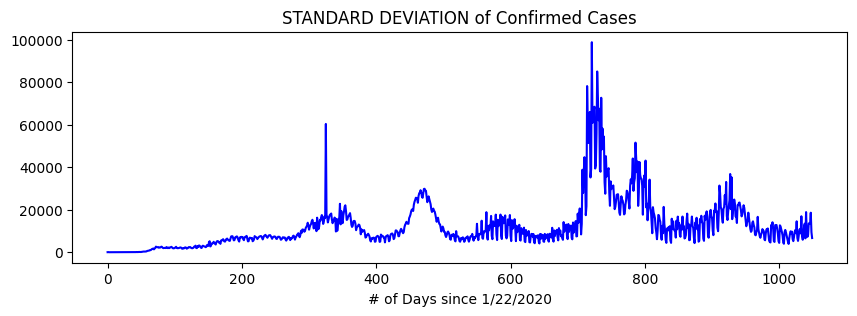

C:\Users\Student\AppData\Local\Temp\ipykernel_900\477869190.py:72: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  list_std = df_deaths.std(axis=0)


Max Standard Deviation date in Deaths:  3/24/22
Min Standard Deviation date in Deaths:  1/25/20


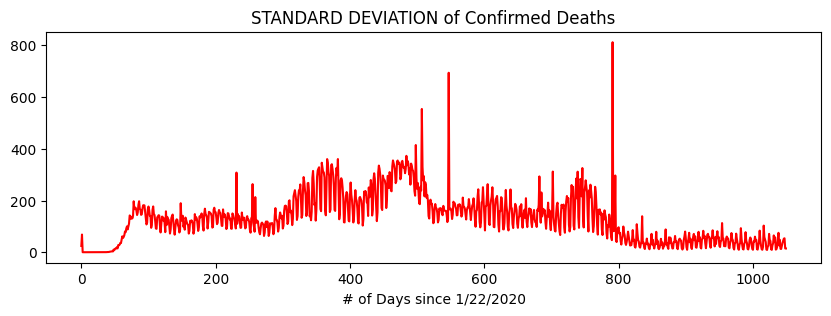

C:\Users\Student\AppData\Local\Temp\ipykernel_900\477869190.py:86: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  list_variance_cases = df_cases.var(axis=0)


Max Variance date in Confirmed cases:  1/13/22
Min Variance date in Confirmed cases:  1/25/20


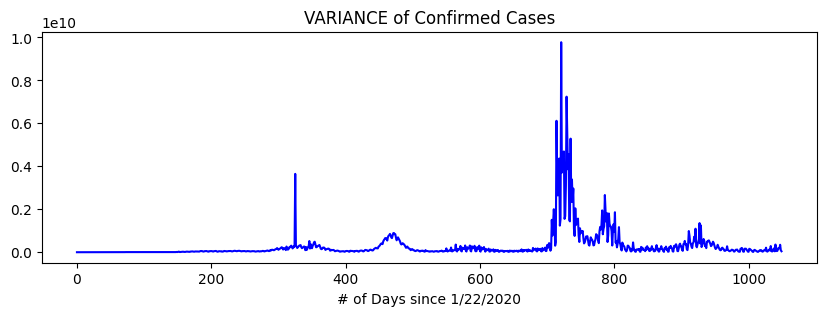

C:\Users\Student\AppData\Local\Temp\ipykernel_900\477869190.py:100: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  list_variance = df_deaths.var(axis=0)


Max Variance date in Deaths:  3/24/22
Min Variance date in Deaths:  1/25/20


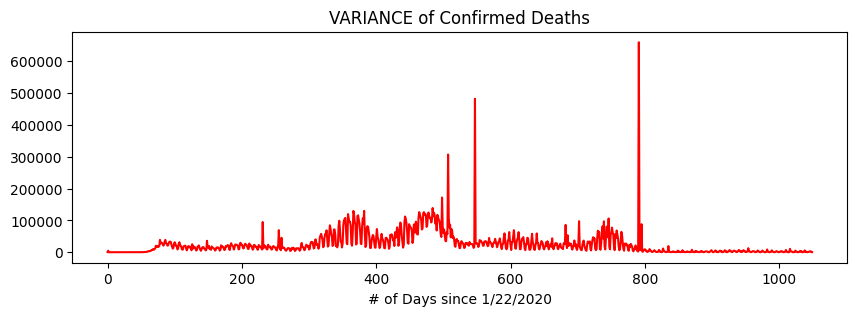

C:\Users\Student\AppData\Local\Temp\ipykernel_900\477869190.py:114: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  list_aad_cases = df_cases.mad(axis=0)


Max AAD date in Confirmed cases:  1/22/22
Min AAD date in Confirmed cases:  1/25/20


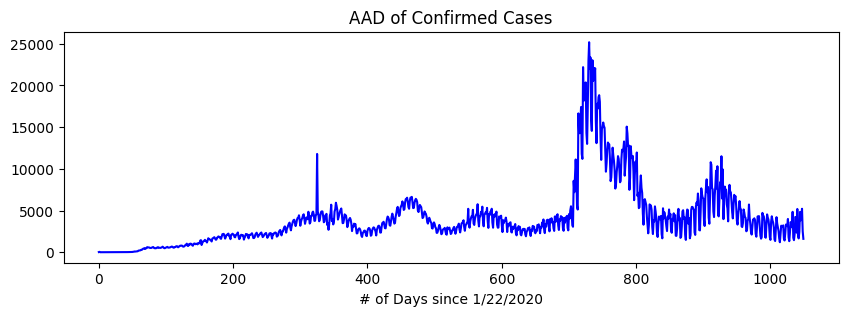

C:\Users\Student\AppData\Local\Temp\ipykernel_900\477869190.py:128: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  list_aad = df_deaths.mad(axis=0)


Max AAD date in Deaths:  7/23/21
Min AAD date in Deaths:  1/25/20


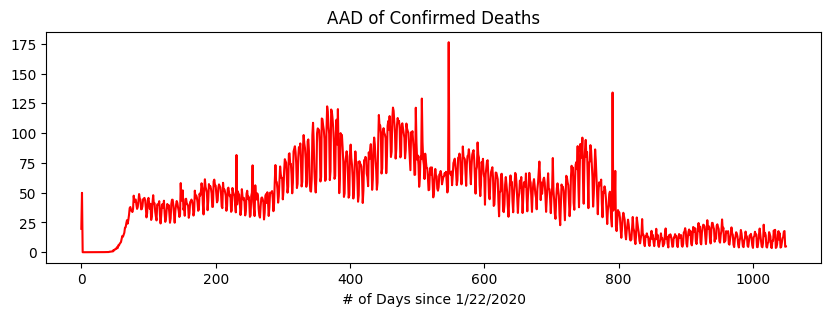

Max MAD date in Confirmed Cases:  1/22/22
Min MAD date in Confirmed Cases: 1/23/20


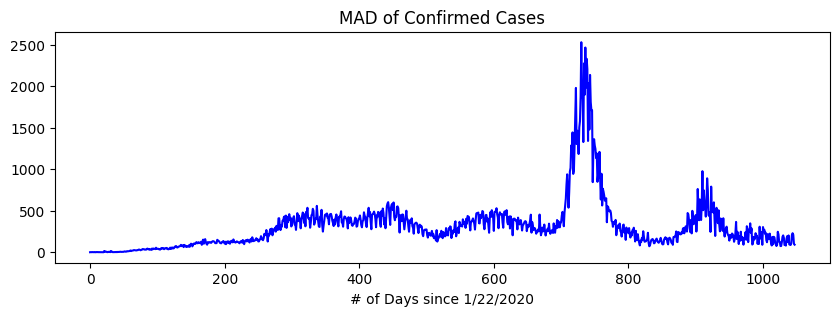

Max MAD date in Deaths:  11/27/20
Min MAD date in Deaths:  1/23/20


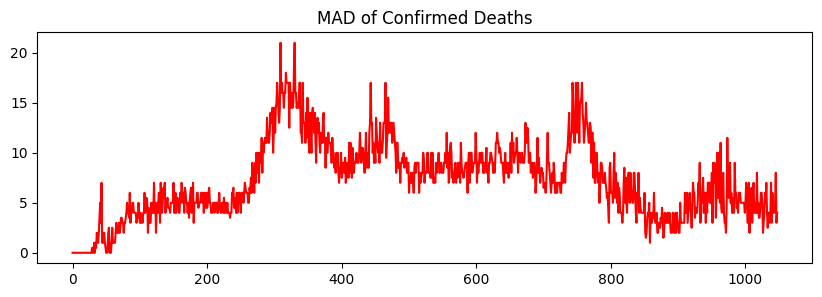

In [89]:
mean_cases()
mean_deaths()

median_cases()
median_deaths()

std_cases()
std_deaths()

variance_cases()
variance_deaths()

aad_cases()
aad_deaths()

mad_cases()
mad_deaths()